# Drag Coefficient Comparison
This notebook looks into the effect of the namelist parameter `mo_drag_use_w_atm_const` for the no-WISHE experiments (`w_atm_const > 0`).

If `mo_drag_use_w_atm_const = .true.`, the constant wind (`w_atm_const = 10` $m/s$ used here) is used to compute the drag coefficient, $C_q$ and $C_t$ in the equations for latent and sensible heat respectively.

If `mo_drag_use_w_atm_const = .false.`, the actual variable wind field, `w_atm`, is used in this calculation.

In both cases, the wind used in the latent and sensible flux equations is `w_atm_const` as it is a no-WISHE experiment.

In [7]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import lcl_temp, rh_from_sphum, saturation_vapor_pressure, mixing_ratio_from_sphum, dry_profile, moist_profile, mixing_ratio_from_partial_pressure, moist_static_energy, convection_neutral_profile, sphum_sat, clausius_clapeyron_factor
from isca_tools.utils.radiation import frierson_net_toa_sw_dwn
from isca_tools.utils.constants import kappa, epsilon
from isca_tools.utils import area_weight_mean_lat, annual_mean
from isca_tools.utils.constants import c_p, R, R_v, kappa, L_v
from isca_tools.thesis.hottest_date import get_maxima_date_from_spline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy.interpolate import CubicSpline
import copy

In [131]:
# Load dataset
var_keep = ['flux_t', 'flux_lhe', 'temp', 'ps', 'sphum', 't_surf', 'w_atm', 'drag_q', 'drag_t', 'rho', 'q_atm', 'q_surf', 't_atm', 'p_atm', 
            'lwdn_sfc', 'lwup_sfc', 'swdn_sfc']
exp_names = ['aquaplanet/no_wishe/k=1', 'aquaplanet/no_wishe/k=1_normal_drag']
n_exp = len(exp_names)
exp_labels = ['constant wind drag', 'normal drag']
use_time_start = 360*2
# only load in atmos level closest to surface, for times after spin up
ds_base = [isca_tools.load_dataset(exp_names[i]).sel(pfull=np.inf, method='nearest')[var_keep] for i in range(n_exp)] 
for i in range(n_exp):
    ds_base[i] = ds_base[i].sel(time=slice(use_time_start, np.inf))
# namelist = isca_tools.load_namelist(exp_names[0])  # Need this for albedo_value
w_atm_const = [isca_tools.load_namelist(exp_names[i])['surface_flux_nml']['w_atm_const'] for i in range(n_exp)]

In [132]:
n_year_days = 360
time_array = np.arange(n_year_days)
ds_global = [annual_mean(ds_base[i]).mean(dim='lon').load() for i in range(n_exp)]
n_lat = len(ds_global[0].lat)

In [272]:
# Get dates of maximum temperature
def get_temp_max_date(t_surf, time=time_array, spline_spacing=20, thresh='mean', n_maxima=2):
    # Return date corresponding to maxima temperature
    t_surf_spline = CubicSpline(np.append(time, time[-1] + 1)[::spline_spacing], np.append(t_surf, t_surf[0])[::spline_spacing], bc_type='periodic')
    if thresh == 'mean':
        temp_thresh = float(t_surf.mean())
    elif isinstance(thresh, float):
        temp_thresh = thresh
    elif thresh is None:
        temp_thresh = 0
    else:
        raise ValueError('temp thresh not valid')
    return get_maxima_date_from_spline(t_surf_spline, thresh=temp_thresh, n_maxima=n_maxima)

max_temp_date = np.zeros((n_exp, n_lat, 2))
for i in range(n_exp):
    for j in range(n_lat):
        max_temp_date[i, j] = get_temp_max_date(ds_global[i].t_surf.isel(lat=j))
        
max_temp_date = np.sort(max_temp_date, axis=-1) # sort so plots better

## Hottest Date of the Year
See how the date of the hottest day of the year varies with how the drag coefficient is computed.

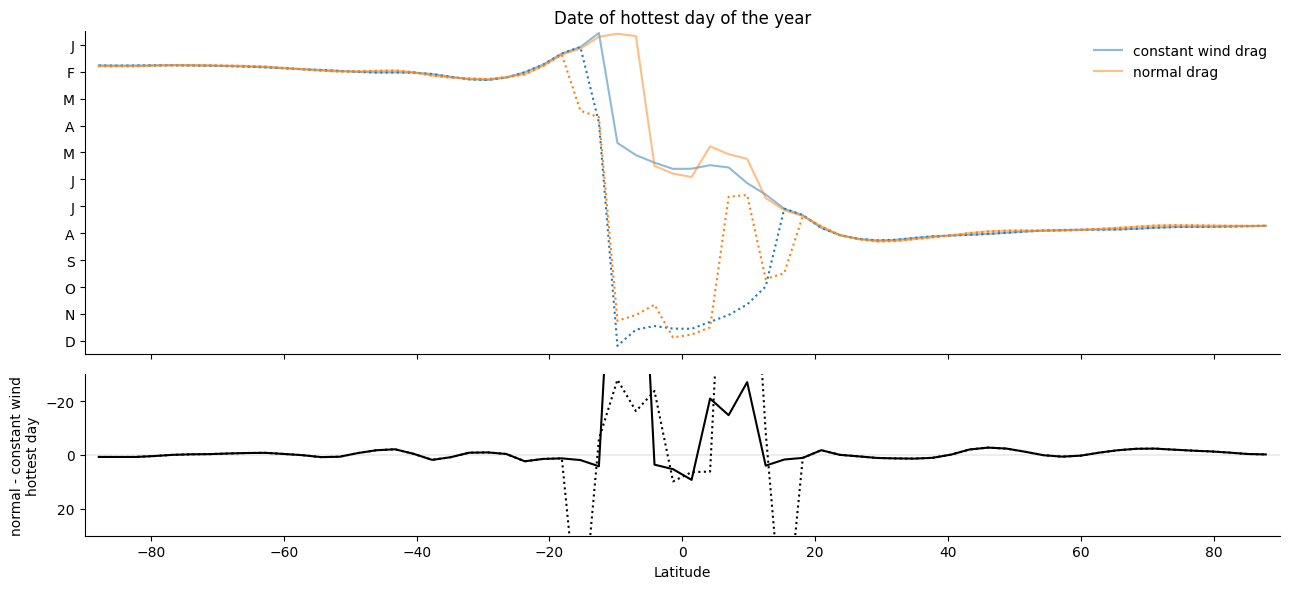

In [273]:
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
month_ticks = (np.arange(15,12*30+15,30), ['J','F','M','A','M','J','J','A','S','O','N','D'])

fig, ax = plt.subplots(2,1, figsize=(13, 6), height_ratios=[2,1], sharex=True)
ax[0].spines[['top', 'right']].set_visible(False)
ax[1].spines[['top', 'right']].set_visible(False)
for i in range(n_exp):
    ax[0].plot(ds_global[0].lat, max_temp_date[i,:,0], color=default_colors[i], alpha=0.5, label=exp_labels[i])
    ax[0].plot(ds_global[0].lat, max_temp_date[i,:,1], color=default_colors[i], linestyle=':')
ax[1].plot(ds_global[0].lat, max_temp_date[1,:,0] - max_temp_date[0,:,0], color='k')
ax[1].plot(ds_global[0].lat, max_temp_date[1,:,1] - max_temp_date[0,:,1], color='k', linestyle=':')
ax[1].hlines(0, -90, 90, lw=0.1, color='k')
ax[0].set_xlim(-90, 90)
ax[1].set_ylim(-30,30)
ax[1].set_ylabel('normal - constant wind\nhottest day')
ax[0].set_yticks(*month_ticks)
ax[0].set_ylim(0, n_year_days)
ax[0].legend(frameon=False)
ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[1].set_xlabel('Latitude')
ax[0].set_title('Date of hottest day of the year')
plt.tight_layout()

## Single Location
Look at the seasonal temperature profile at a specific latitude, to diagnose the differences - do they occur solely due to changes in the drag coefficient, $C_q$?

In [293]:
# Consider a single latitude
loc = {'lat': 46}
ds_sl = [ds_global[i].sel(lat=loc['lat'], method='nearest') for i in range(n_exp)]
lat_sl_ind = int(np.where(ds_global[0].lat==ds_sl[0].lat)[0])

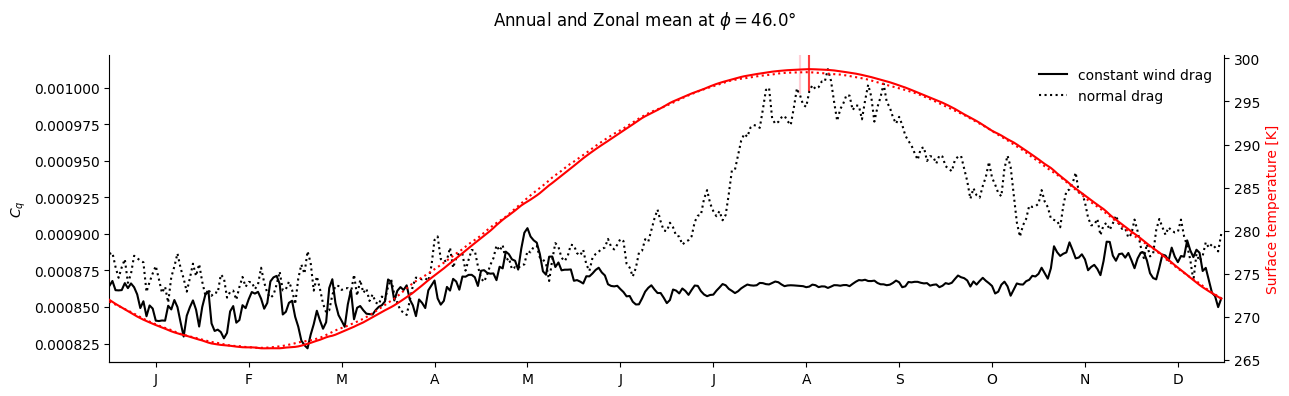

In [294]:
linestyles = ['-', ':']

fig, ax = plt.subplots(1,1, figsize=(13, 4))
for i in range(n_exp):
    ax.plot(time_array, ds_sl[i].drag_q, label=exp_labels[i], color='k', linestyle=linestyles[i])
ax2 = ax.twinx()
for i in range(n_exp):
    ax2.plot(time_array, ds_sl[i].t_surf, color='r', linestyle=linestyles[i])
for i in range(n_exp):
    for j in range(2):
        ax2.scatter(max_temp_date[i, lat_sl_ind, j], ds_sl[i].t_surf[np.argmin(np.abs(time_array-max_temp_date[i, lat_sl_ind, j]))], 
                    color='red' if i==0 else 'pink', alpha=0.5, marker='|', s=1000)
ax.set_xticks(*month_ticks)
ax.set_xlim(0, n_year_days)
ax.set_ylabel('$C_q$', color='k')
ax2.set_ylabel('Surface temperature [K]', color='r')
ax.spines[['top', 'right']].set_visible(False)
ax2.spines[['top', 'left']].set_visible(False)
ax.legend(frameon=False)
fig.suptitle(f"Annual and Zonal mean at $\phi={round(float(ds_sl[0].lat), 1)}\degree$")
plt.tight_layout()

### Wind Plot
Show that the drag coefficient is large wherever the horizontal wind is small for the normal drag experiment.

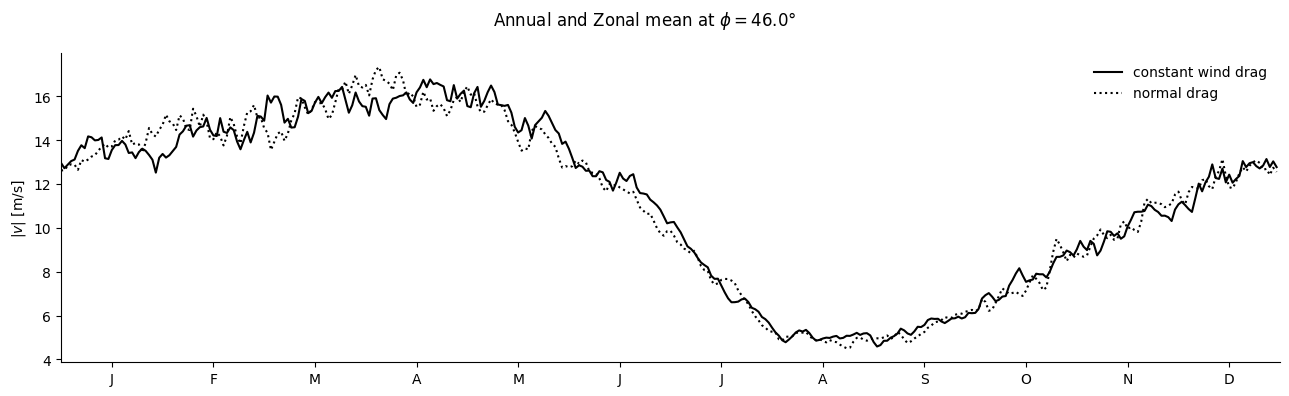

In [295]:
fig, ax = plt.subplots(1,1, figsize=(13, 4))
for i in range(n_exp):
    ax.plot(time_array, ds_sl[i].w_atm, label=exp_labels[i], color='k', linestyle=linestyles[i])
ax.legend(frameon=False)
ax.spines[['top', 'right']].set_visible(False)
ax.set_xticks(*month_ticks)
ax.set_xlim(0, n_year_days)
ax.set_ylabel('$|v|$ [m/s]')
fig.suptitle(f"Annual and Zonal mean at $\phi={round(float(ds_sl[0].lat), 1)}\degree$")
plt.tight_layout()
# plt.plot((ds_global[1].t_surf - ds_global[0].t_surf).max(dim='time'))

### Surface Fluxes
Look at how the drag coefficient affects the surface fluxes.

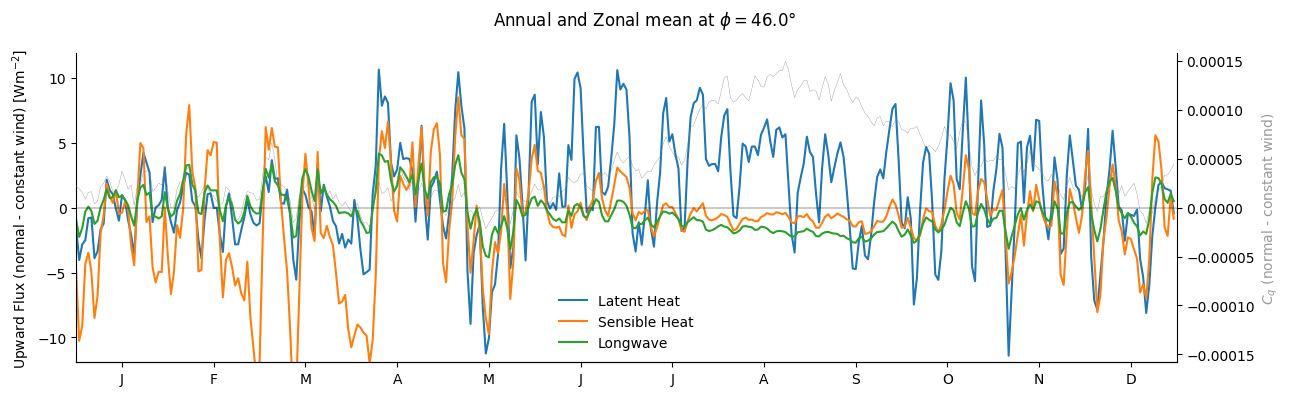

In [297]:
fig, ax = plt.subplots(1,1, figsize=(13, 4))
ax.plot(time_array, ds_sl[1].flux_lhe-ds_sl[0].flux_lhe, color=default_colors[0], label='Latent Heat')
ax.plot(time_array, ds_sl[1].flux_t-ds_sl[0].flux_t, color=default_colors[1], label='Sensible Heat')
ax.plot(time_array, (ds_sl[1].lwup_sfc - ds_sl[1].lwdn_sfc)-(ds_sl[0].lwup_sfc - ds_sl[0].lwdn_sfc), color=default_colors[2], label='Longwave')
ax.hlines(0, 0, n_year_days, colors='k', lw=0.3)
ax.legend(frameon=False)
ax.set_ylim(-ax.get_ylim()[1], ax.get_ylim()[1])
ax.spines[['top', 'right']].set_visible(False)
ax.set_xticks(*month_ticks)
ax.set_xlim(0, n_year_days)
ax.set_ylabel('Upward Flux (normal - constant wind) [Wm$^{-2}$]')

ax2 = ax.twinx()
ax2.spines[['top', 'left']].set_visible(False)
ax2.plot(time_array, ds_sl[1].drag_q - ds_sl[0].drag_q, color='grey', lw=0.3, alpha=0.8)
ax2.set_ylim(-ax2.get_ylim()[1], ax2.get_ylim()[1])
ax2.set_ylabel('$C_q$ (normal - constant wind)', color='grey', alpha=0.8)

fig.suptitle(f"Annual and Zonal mean at $\phi={round(float(ds_sl[0].lat), 1)}\degree$")
plt.tight_layout()

### Other Flux contributions
Latent heat flux also depends on relative humidity, $r_a$, and the difference between the surface and atmosphere, $T_{a-s}$ as well as the drag coefficient, $C_q$. Sensible heat also depends on $T_{a-s}$ so lets look at how the drag coefficient calculation affect these.

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(13, 4))
ax.plot(time_array, ds_sl[1].flux_lhe-ds_sl[0].flux_lhe, color=default_colors[0], label='Latent Heat')
ax.plot(time_array, ds_sl[1].flux_t-ds_sl[0].flux_t, color=default_colors[1], label='Sensible Heat')
ax.plot(time_array, (ds_sl[1].lwup_sfc - ds_sl[1].lwdn_sfc)-(ds_sl[0].lwup_sfc - ds_sl[0].lwdn_sfc), color=default_colors[2], label='Longwave')
ax.hlines(0, 0, n_year_days, colors='k', lw=0.3)
ax.legend(frameon=False)
ax.set_ylim(-ax.get_ylim()[1], ax.get_ylim()[1])
ax.spines[['top', 'right']].set_visible(False)
ax.set_xticks(*month_ticks)
ax.set_xlim(0, n_year_days)
ax.set_ylabel('Upward Flux (normal - constant wind) [Wm$^{-2}$]')

ax2 = ax.twinx()
ax2.spines[['top', 'left']].set_visible(False)
ax2.plot(time_array, ds_sl[1].drag_q - ds_sl[0].drag_q, color='grey', lw=0.3, alpha=0.8)
ax2.set_ylim(-ax2.get_ylim()[1], ax2.get_ylim()[1])
ax2.set_ylabel('$C_q$ (normal - constant wind)', color='grey', alpha=0.8)

fig.suptitle(f"Annual and Zonal mean at $\phi={round(float(ds_sl[0].lat), 1)}\degree$")
plt.tight_layout()

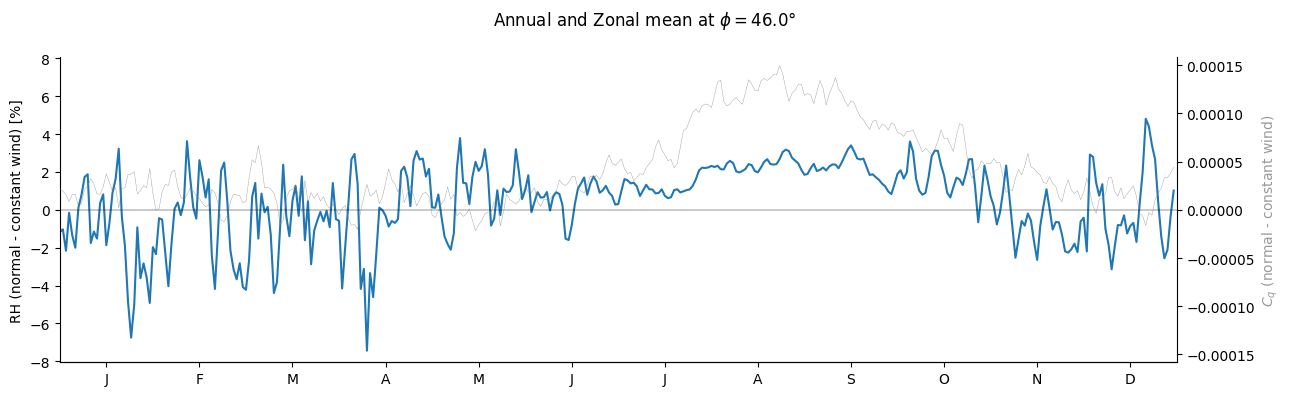

In [310]:
fig, ax = plt.subplots(1,1, figsize=(13, 4))
ax.plot(time_array, 100 * ds_sl[1].q_atm/sphum_sat(ds_sl[1].t_atm, ds_sl[1].p_atm)- 100 * ds_sl[0].q_atm/sphum_sat(ds_sl[0].t_atm, ds_sl[0].p_atm))
ax.spines[['top', 'right']].set_visible(False)
ax.set_xticks(*month_ticks)
ax.set_xlim(0, n_year_days)
ax.hlines(0, 0, n_year_days, colors='k', lw=0.3)
ax.set_ylim(-np.abs(ax.get_ylim()).max(), np.abs(ax.get_ylim()).max())
ax.set_ylabel('RH (normal - constant wind) [%]')

ax2 = ax.twinx()
ax2.spines[['top', 'left']].set_visible(False)
ax2.plot(time_array, ds_sl[1].drag_q - ds_sl[0].drag_q, color='grey', lw=0.3, alpha=0.8)
ax2.set_ylim(-ax2.get_ylim()[1], ax2.get_ylim()[1])
ax2.set_ylabel('$C_q$ (normal - constant wind)', color='grey', alpha=0.8)
ax2.set_ylim(-np.abs(ax2.get_ylim()).max(), np.abs(ax2.get_ylim()).max())

fig.suptitle(f"Annual and Zonal mean at $\phi={round(float(ds_sl[0].lat), 1)}\degree$")
plt.tight_layout()

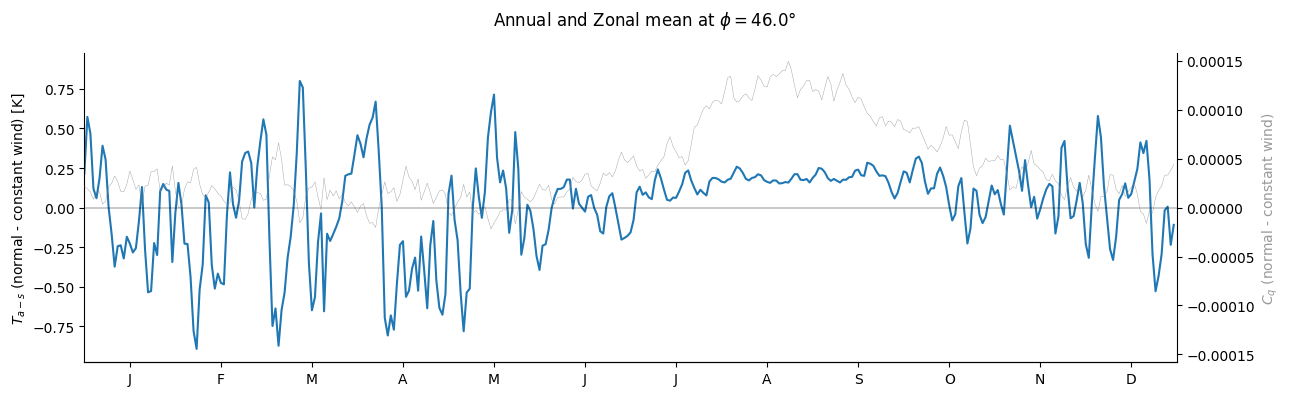

In [312]:
fig, ax = plt.subplots(1,1, figsize=(13, 4))
ax.plot(time_array, ds_sl[1].t_atm - ds_sl[1].t_surf - (ds_sl[0].t_atm - ds_sl[0].t_surf))
ax.spines[['top', 'right']].set_visible(False)
ax.set_xticks(*month_ticks)
ax.set_xlim(0, n_year_days)
ax.hlines(0, 0, n_year_days, colors='k', lw=0.3)
ax.set_ylim(-np.abs(ax.get_ylim()).max(), np.abs(ax.get_ylim()).max())
ax.set_ylabel('$T_{a-s}$ (normal - constant wind) [K]')

ax2 = ax.twinx()
ax2.spines[['top', 'left']].set_visible(False)
ax2.plot(time_array, ds_sl[1].drag_q - ds_sl[0].drag_q, color='grey', lw=0.3, alpha=0.8)
ax2.set_ylim(-ax2.get_ylim()[1], ax2.get_ylim()[1])
ax2.set_ylabel('$C_q$ (normal - constant wind)', color='grey', alpha=0.8)
ax2.set_ylim(-np.abs(ax2.get_ylim()).max(), np.abs(ax2.get_ylim()).max())

fig.suptitle(f"Annual and Zonal mean at $\phi={round(float(ds_sl[0].lat), 1)}\degree$")
plt.tight_layout()

In [314]:
ds_sl[0].pfull

<xarray.DataArray 'pfull' ()>
array(994.87004887)
Coordinates:
    lat      float64 46.04
    pfull    float64 994.9
Attributes:
    long_name:       approx full pressure level
    units:           hPa
    cartesian_axis:  Z
    positive:        down